In [124]:
import numpy as np
import tkinter as tk
from tkinter import filedialog
from tkinter import ttk
import pandas as pd
import skfuzzy as fuzz
from skfuzzy import control as ctrl
import pickle
import matplotlib.pyplot as plt
import scipy.stats as stats
from matplotlib.backends.backend_pdf import PdfPages

def CDG():
    # Crear una ventana raÃ­z
    root = tk.Tk()
    root.withdraw()  # Ocultar la ventana principal
    # Hacer que la ventana estÃ© siempre en el frente
    root.attributes('-topmost', True)
    # Abrir un cuadro de diÃ¡logo para seleccionar un archivo CSV
    file_path = filedialog.askopenfilename(
        title="Selecciona un archivo CSV para generar la CDG",
        filetypes=(("CSV files", "*.csv"), ("Todos los archivos", "*.*")))

    # Mostrar la ruta del archivo seleccionado
    print(f"Archivo seleccionado: {file_path}")
    # Cerrar la ventana raÃ­z
    root.destroy()
    
    if file_path:  # Verificar si se seleccionÃ³ un archivo
        try:
            df = pd.read_csv(file_path)
        except Exception as e:
            print(f"Error al leer el archivo: {e}")
    else:
        print("No se seleccionÃ³ ningÃºn archivo.")
        
    df.set_index(df.columns[0], inplace=True)
    df.iloc[:,1:]
    
    # Diccionario de DF por cada estaciÃ³n
    Estaciones = {}
    Percentiles = {}
    # Percentilies deseados
    Prob = [10, 50, 90]
        
    for columna in df.columns:
        # Crear un DataFrame para cada estaciÃ³n y ordenarlo
        est = df[[columna]].dropna().sort_values(by=columna, ascending=False).reset_index(drop=True)
        est = est.iloc[:-3,:]
        est = est.iloc[1:,:]
        est['Probabilidad'] = 100*(est.index + 1) / (len(est) + 1)
        Estaciones[columna] = est
            
        i = 0
        P = pd.DataFrame(np.zeros((len(Prob), 2)), columns=['Nivel', 'Probabilidad'])

        for p in Prob:
            idx = (est.iloc[:, 1] - p).abs().idxmin()
            P.at[i, 'Nivel'] = float("{:.2f}".format(est.iloc[idx, 0]))
            P.at[i, 'Probabilidad'] = float("{:.2f}".format(est.iloc[idx, 1]))
            i = i + 1
        Percentiles[columna] = P.copy()
    
    return Percentiles  

def LeerArchivos(a):
    # Crear una ventana raíz
    root = tk.Tk()
    root.withdraw()  # Ocultar la ventana principal
    # Hacer que la ventana esté siempre en el frente
    root.attributes('-topmost', True)
    # Abrir un cuadro de diálogo para seleccionar un archivo CSV
    file_path = filedialog.askopenfilename(
        title=f"Selecciona un archivo CSV de {a}",
        filetypes=(("CSV files", "*.csv"), ("Todos los archivos", "*.*")))
    # Mostrar la ruta del archivo seleccionado
    print(f"Archivo seleccionado: {file_path}")

    # Cerrar la ventana raíz
    root.destroy()
        
    if file_path:  # Verificar si se seleccionó un archivo
        try:
            df = pd.read_csv(file_path)
        except Exception as e:
            print(f"Error al leer el archivo: {e}")
    else:
        print("No se seleccionó ningún archivo.")
                
    df = df.iloc[:,1:] #EliminarFecahs
        
    return df

def ElegirEstacion(Data):
    
    def Seleccion():
        columna_seleccionada = columna_var.get()
        print(f"Has seleccionado la estación: {columna_seleccionada}")
        root.destroy()  # Cierra la ventana
    
    # Crear la ventana principal de Tkinter
    root = tk.Tk()
    root.title("Selecciona una estación")
    # Hacer que la ventana esté siempre en el frente
    root.attributes('-topmost', True)
    # Variable para almacenar la selección
    columna_var = tk.StringVar()
    columna_var.set(Data.columns[0])  # Valor inicial en el OptionMenu
    dropdown = ttk.OptionMenu(root, columna_var, *Data.columns)
    dropdown.pack(pady=10)
    # Botón para confirmar la selección
    boton = tk.Button(root, text="Seleccionar", command = Seleccion)
    boton.pack(pady=20)
    # Iniciar la ventana
    root.mainloop()
    columna_seleccionada = columna_var.get()
    
    return columna_seleccionada

def LogicaDifusa(P, N):
    
    # Antecedentes (precipitaciónn y nivel) y consecuente (Nivel o caudal)
    PrecP = ctrl.Antecedent(np.linspace(P[EstP].iloc[-dias_pasados:].min(), P[EstP].iloc[-dias_pasados:].max(), num=5), 'Precipitación Pasada')
    #PrecP2 = ctrl.Antecedent(np.linspace(P[EstP].iloc[-dias_pasados:].min(), P[EstP].iloc[-dias_pasados:].max(), num=5), 'Precipitación Pasada2')
    NivP = ctrl.Antecedent(np.linspace(N[EstN].min(), N[EstN].max(), num=3), 'Nivel Pasado')
    Niv = ctrl.Consequent([N[EstN].min(), Percentiles[EstN].iloc[2,0], Percentiles[EstN].iloc[1,0], Percentiles[EstN].iloc[0,0], N[EstN].max()], 'Nivel')
    
    # Auto-membership function population is possible with .automf(3, 5, or 7)
    PrecP.automf(5) #poor, mediocre , average, decent ,good
    #PrecP2.automf(5)
    NivP.automf(3) #poor, average, good
    
    # DefiniciÃ³n de membresÃ­as para Nivel
    Niv['Bajo (90-100%)'] = fuzz.trimf(Niv.universe, [N[EstN].min(), N[EstN].min(), Percentiles[EstN].iloc[2,0]])
    Niv['Medio-Bajo (50-90%)'] = fuzz.trimf(Niv.universe, [N[EstN].min(), Percentiles[EstN].iloc[2,0], Percentiles[EstN].iloc[1,0]])
    Niv['Medio (10-50%)'] = fuzz.trimf(Niv.universe, [Percentiles[EstN].iloc[2,0], Percentiles[EstN].iloc[1,0], Percentiles[EstN].iloc[0,0]])
    Niv['Alto (0-10%)'] = fuzz.trapmf(Niv.universe, [Percentiles[EstN].iloc[1,0], Percentiles[EstN].iloc[0,0], N[EstN].max(), N[EstN].max()])

    # REGLAS
    Pp = ctrl.Rule(PrecP['poor'], Niv['Medio-Bajo (50-90%)'])
    Pm = ctrl.Rule(PrecP['mediocre'], Niv['Medio (10-50%)'])
    Pa = ctrl.Rule(PrecP['average'], Niv['Medio (10-50%)'])
    Pd = ctrl.Rule(PrecP['decent'], Niv['Alto (0-10%)'])
    Pg = ctrl.Rule(PrecP['good'], Niv['Alto (0-10%)'])
    
    """Pp2 = ctrl.Rule(PrecP2['poor'], Niv['Medio-Bajo (50-90%)'])
    Pm2 = ctrl.Rule(PrecP2['mediocre'], Niv['Medio (10-50%)'])
    Pa2 = ctrl.Rule(PrecP2['average'], Niv['Alto (0-10%)'])
    Pd2 = ctrl.Rule(PrecP2['decent'], Niv['Alto (0-10%)'])
    Pg2 = ctrl.Rule(PrecP2['good'], Niv['Alto (0-10%)'])"""

    Np = ctrl.Rule(NivP['poor'], Niv['Bajo (90-100%)'])
    Na = ctrl.Rule(NivP['average'], Niv['Medio (10-50%)'])
    Ng = ctrl.Rule(NivP['good'], Niv['Alto (0-10%)'])
    
    Nivel_ctrl = ctrl.ControlSystem([Pp, Pm, Pa, Pd, Pg, Np, Na, Ng]) #, Pp2, Pm2, Pa2, Pd2, Pg2
    Nivel = ctrl.ControlSystemSimulation(Nivel_ctrl)
    
    NivelReal = N[EstN].iloc[-dias_pasados+1:]
    NivelReal.index = range(dias_pasados-1)
    Pronosticos = pd.DataFrame(np.nan, index=range(dias_pasados), columns=[f"Día {i+1}" for i in range(dias_futuros)], dtype=float)

    resultados = []

    for i in range(dias_pasados):
        
        a = dias_pasados - i
        
        def Pron_Estad():
            precip = np.array([DatosPrec[EstP]])  # Aquí van tus datos de precipitación históricos
            precip = precip[~np.isnan(precip)]
             
            # Ajuste de la distribución Gamma a los datos históricos de precipitación
            params = stats.pareto.fit(precip)
            
            # Generar pronósticos a partir de X días y usando Y días futuros
            pronostico_futuro = pd.DataFrame({EstP: stats.pareto.rvs(*params, size=dias_futuros - 1)})
            Pre_P = DatosPrec[EstP].iloc[[-a]].to_frame()
            Pre_P2 = DatosPrec[EstP].iloc[[-a-1,-a]].to_frame()
            Pre_P2.columns = [0]
            Prec_Pron = pd.concat([Pre_P, pronostico_futuro], ignore_index=True)
            Prec_Pron2 = pd.concat([Pre_P2, pronostico_futuro.iloc[1:,0]], ignore_index=True)    
            
            return Prec_Pron, Prec_Pron2
        
        Prec_Pron, Prec_Pron2 = Pron_Estad()
        Nivel_Pron = DatosNiv[EstN].iloc[[-a]].to_frame().reset_index(drop=True)
        for dia in range(dias_futuros):
            
            Nivel.input['Precipitación Pasada'] = Prec_Pron.iloc[dia]
            #Nivel.input['Precipitación Pasada2'] = Prec_Pron2.iloc[dia]
            Nivel.input['Nivel Pasado'] = Nivel_Pron.iloc[dia]
            Nivel.compute()
            Nivel_Pron.loc[len(Nivel_Pron)] = float(Nivel.output['Nivel'])
            Pronosticos.iloc[i, dia] = float(Nivel.output['Nivel'])
            
    for i in range(dias_futuros):
        
        a = dias_pasados - i
        b = a-1
        
        RMSE = np.sqrt(np.mean((NivelReal[-a:] - Pronosticos.iloc[:a,i]) ** 2))
        MAE = np.mean(np.abs(NivelReal[-a:] - Pronosticos.iloc[:a,i]))
        r2 = 1 - (np.sum((NivelReal[-a:] - Pronosticos.iloc[:a,i]) ** 2) / np.sum((NivelReal[-a:] - np.mean(NivelReal[-a:])) ** 2))
        
        # Almacenar los resultados
        resultados.append([RMSE, MAE, r2])
        
        plt.figure()
        plt.title(f'Día {i+1}')
        plt.plot(range(dias_pasados), Pronosticos[f'Día {i+1}'], label = 'Nivel pronosticado')
        plt.plot(range(b), NivelReal[-b:], label = 'Nivel real')
        plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15))

        plt.text(1, Pronosticos.max().max(), f'RMSE: {RMSE:.4f}\nMAE: {MAE:.4f}\nR²: {r2:.4f}', 
             bbox=dict(facecolor='white', alpha=0.5))
        
    df_resultados = pd.DataFrame(resultados, columns=['RMSE', 'MAE', 'R²'], index=[f'Día {i+1}' for i in range(7)])
    
    return NivelReal, Pronosticos, Prec_Pron, Nivel_Pron, df_resultados, PrecP, NivP, Niv

In [40]:
Percentiles = CDG()
DatosPrec = LeerArchivos("Precipitacion")
DatosNiv = LeerArchivos("Nivel")

dias_pasados = int(input("Ingrese el número de días pasados: "))
dias_futuros = int(input("Ingrese el número de días futuros: "))

EstN = ElegirEstacion(DatosNiv)

Archivo seleccionado: C:/Users/juanj/Downloads/H12H42/H12/Niveles_H12.csv
Archivo seleccionado: C:/Users/juanj/Downloads/H12H42/H12/Seleccionado/Prec_H12_relleno.csv
Archivo seleccionado: C:/Users/juanj/Downloads/H12H42/H12/Seleccionado/Niveles_H12_relleno.csv


Ingrese el número de días pasados:  2015
Ingrese el número de días futuros:  7


Has seleccionado la estación: H12, Pita Bocatoma


In [110]:
EstP = ElegirEstacion(DatosPrec)

Has seleccionado la estación: ATP01PT02, (Tung/Cham)


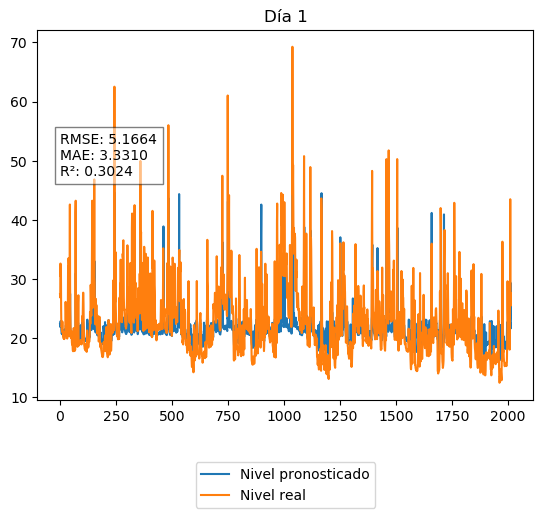

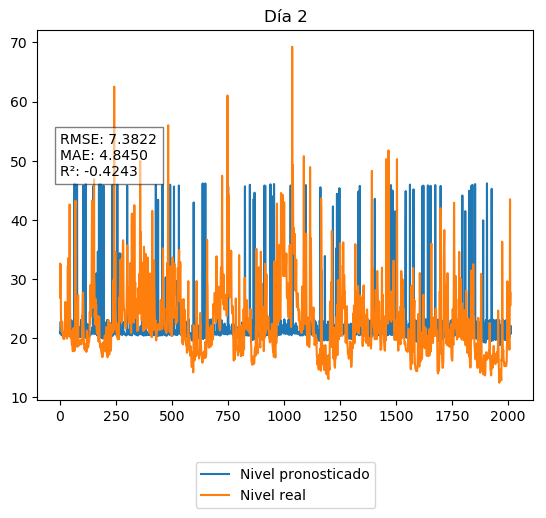

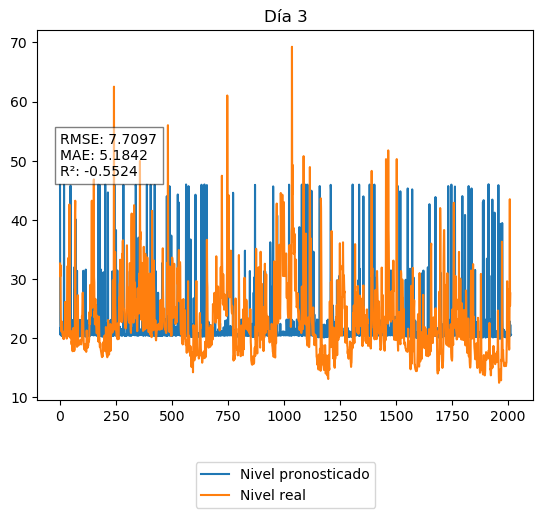

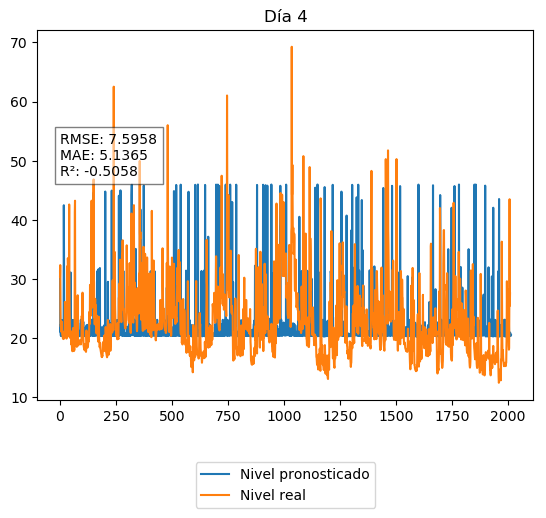

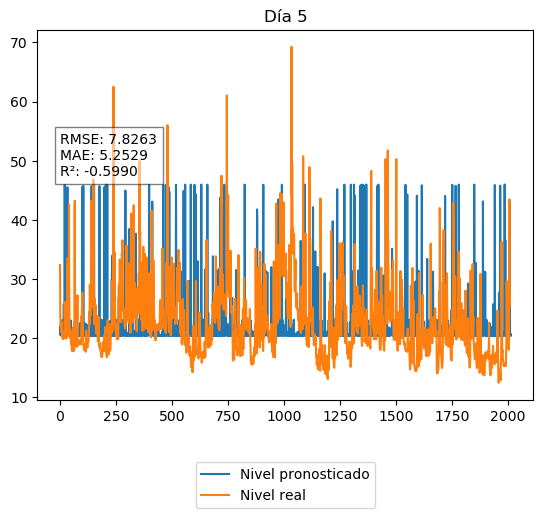

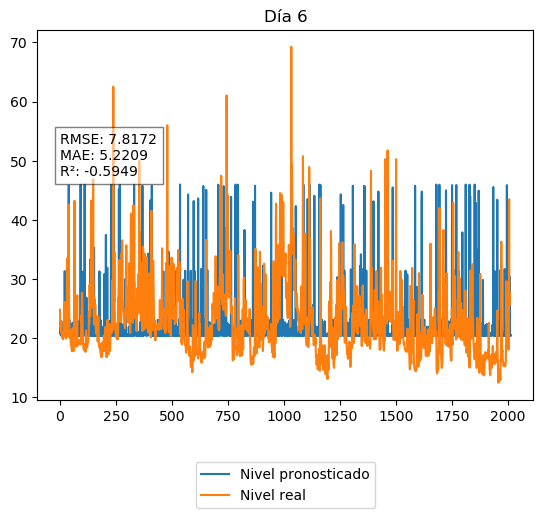

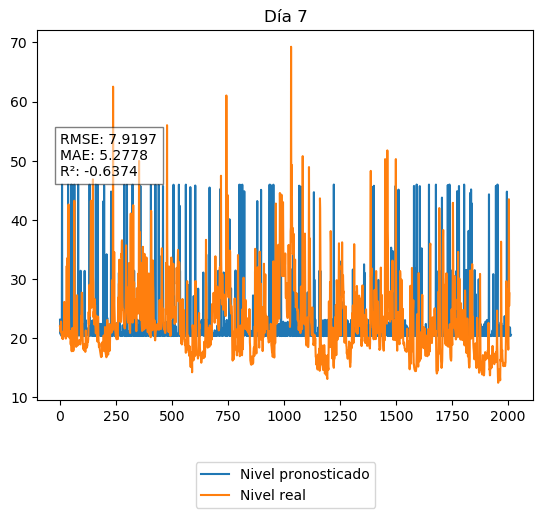

In [125]:
NivelReal, Pronosticos, Prec_Pron, Nivel_Pron, Error, PrecP, NivP, Niv = LogicaDifusa(DatosPrec, DatosNiv)

In [112]:
# Generar nombre del archivo PDF dinámico basado en variables y nombres de las columnas
pdf_filename = f'Pronostico_H12_Reglas(P,N)T-1_ATP01PT02.pdf'

# Crear el archivo PDF para guardar gráficos y métricas
with PdfPages(pdf_filename) as pdf:
    # Página 1: Información general
    plt.figure(figsize=(8, 6))
    plt.text(0.5, 0.8, 'Variables Utilizadas en el Pronóstico:', ha='center', fontsize=14)
    plt.text(0.5, 0.7, f'H12. Pita Bocatoma,{EstP}', ha='center', fontsize=12)
    plt.text(0.5, 0.6, 'Variable Pronosticada: H12. Pita Bocatoma', ha='center', fontsize=14)
    plt.text(0.5, 0.5, 'Reglas basadas en precipitación t-1 y nivel t-1', ha='center', fontsize=14)
    plt.text(0.5, 0.4, 'Métricas de Ajuste:', ha='center', fontsize=14)
    for i in range(dias_futuros):
        plt.text(0.5, 0.3 - i*0.05, f"Día {i + 1} - RMSE: {Error.iloc[i,0]:.4f}, MAE: {Error.iloc[i,1]:.4f}, R²: {Error.iloc[i,2]:.4f}",
                 ha='center', fontsize=12)
    plt.axis('off')
    pdf.savefig()
    plt.close()

    # Gráficos de predicción vs realidad para cada día
    for day in range(dias_futuros):
        
        b = dias_pasados - day -1
        
        plt.figure(figsize=(10, 5))
        plt.title(f'Pronóstico del Día {day+1}')
        plt.plot(range(dias_pasados), Pronosticos[f'Día {day+1}'], label = 'Nivel pronosticado')
        plt.plot(range(b), NivelReal[-b:], label = 'Nivel real')
        plt.legend()
        plt.grid(True)
        pdf.savefig()
        plt.close()

    # Gráfico de todas las métricas por día
    plt.figure(figsize=(10, 5))
    days = range(1, 8)
    plt.plot(days, Error.iloc[:,0], label='RMSE')
    plt.plot(days, Error.iloc[:,1], label='MAE')
    plt.plot(days, Error.iloc[:,2], label='R²')
    plt.title('Métricas de Pronóstico para Cada Día')
    plt.xlabel('Día de Pronóstico')
    plt.ylabel('Métrica')
    plt.legend()
    plt.grid(True)
    pdf.savefig()
    plt.close()

# Mensaje de finalización
print(f"Resultados y gráficos guardados en el archivo {pdf_filename}.")

Resultados y gráficos guardados en el archivo Pronostico_H12_Reglas(P,N)T-1_ATP01PT02.pdf.


C:\Users\juanj\.conda\envs\Scikit-fuzzi\lib\site-packages\matplotlib\figure.py:456: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  warnings.warn(
C:\Users\juanj\.conda\envs\Scikit-fuzzi\lib\site-packages\matplotlib\figure.py:456: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  warnings.warn(
C:\Users\juanj\.conda\envs\Scikit-fuzzi\lib\site-packages\matplotlib\figure.py:456: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  warnings.warn(


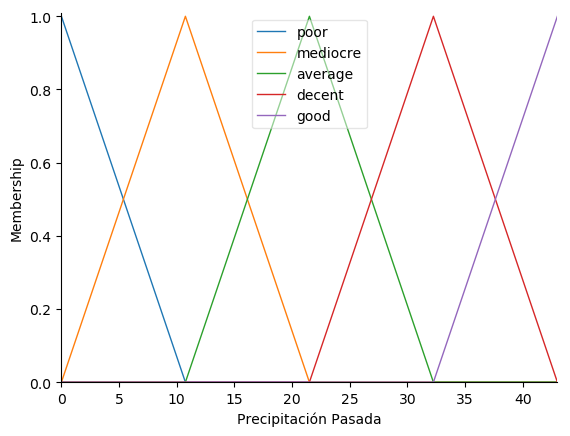

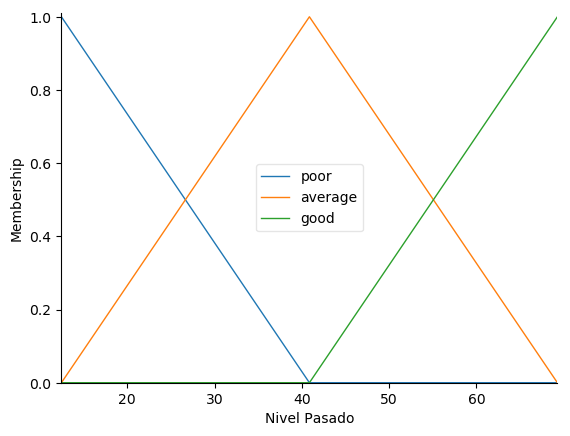

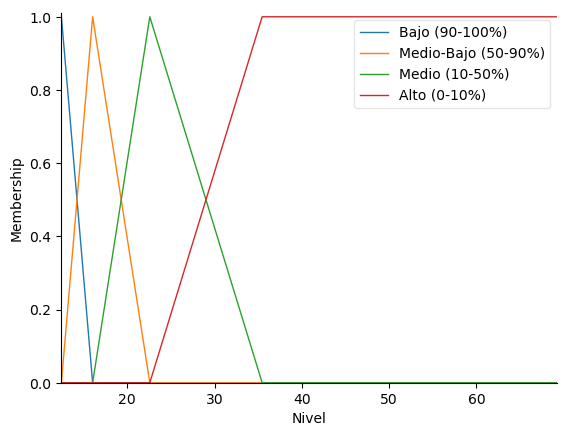

In [126]:
PrecP.view()
NivP.view()
Niv.view()